## Bitcoint price prediction using RNN

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Load dataset

Source: https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd/data?select=BTC-Daily.csv



In [2]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


### Featuring engineering

We will use 2 based feature from the dataset:
- close: the closing price of the day
- volumne_usd: daily transaction volumne in USD

In [ ]:
df = df[['unix', 'close', 'Volume USD']].rename(columns={'Volume USD': 'volume_usd'})
df.set_index('unix', inplace=True)
df = df.sort_index()

## Generate lag and rolling features
df['lag_close_7'] = df['close'].shift(7)
df['lag_close_30'] = df['close'].shift(30)
df['lag_volume_usd_7'] = df['volume_usd'].shift(7)
df['lag_volume_usd_30'] = df['volume_usd'].shift(30)
df['rolling_close_30'] = df['close'].rolling(window=30).mean()
df['rolling_volume_usd_30'] = df['volume_usd'].rolling(window=30).mean()
df.dropna(inplace=True)
df.head()

,close,volume_usd,lag_close_7,lag_close_30,lag_volume_usd_7,lag_volume_usd_30,rolling_close_30,rolling_volume_usd_30
unix,,,,,,,,
1419724800,316.63,4089.61,323.15,376.28,6510.00,8617.15,346.677000,8436.699667
1419811200,314.78,5901.06,330.52,376.72,11646.60,7245.19,344.612333,8391.895333
1419897600,311.94,9894.24,335.49,373.34,7804.03,3046.33,342.565667,8620.159000
1419984000,319.25,6097.71,322.14,378.39,5544.80,6660.56,340.594333,8601.397333
1420070400,316.31,3223.06,319.39,379.25,3924.90,6832.53,338.496333,8481.081667


In [ ]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

### Train Test Split
Test size: 20%

In [ ]:
#Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]


### Build the RNN

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_sizes = hidden_sizes


        # Create multiple RNN layers
        self.rnn_layers = nn.ModuleList()
        current_size = input_size
        for hidden_size in hidden_sizes:
            self.rnn_layers.append(nn.RNN(current_size, hidden_size, batch_first=True))
            current_size = hidden_size

        self.fc = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for i, rnn_layer in enumerate(self.rnn_layers):
          x, h_n = rnn_layer(x)

        out = x[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out


In [ ]:
# Function to prepare sequences for RNN input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Function to train and evaluate the model
def train_and_evaluate(train_data, valid_data, test_data, target_column_index,
                       n_timesteps, num_epochs, hidden_sizes, batch_size, learning_rate):

    # -------------- Prepare model input -------------------------------
    X_train, y_train = create_sequences_multivariate(train_data, n_timesteps, target_column_index)
    X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
    X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

    # Convert to tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # -------------- Initialize model ----------------------
    n_features = train_data.shape[1]
    model = RNNModel(input_size=n_features, hidden_sizes=hidden_sizes, output_size=1)

    # --------------- Define loss function and optimizer --------------------
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # -------------------- Train the model ----------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, valid_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item() * inputs.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on testing set
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test.to(device)).cpu().numpy()
        test_actuals = y_test.numpy()

    return model, train_losses, valid_losses, test_preds, test_actuals

def denormalize(scaled_data, scaler, target_column_index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, target_column_index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, target_column_index]

def metrics_and_plot(test_actuals, test_preds, scaler):
    # Denormalize the predictions and actuals
    test_actuals = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index=0)
    test_preds = denormalize(test_preds, scaler, target_column_index=0)

    # Calculate regression metrics
    mae = mean_absolute_error(test_actuals, test_preds)
    mse = mean_squared_error(test_actuals, test_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_actuals, test_preds)

    # Print metrics
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')

    # Plot predictions vs actuals for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(test_actuals, label='Actual')
    plt.plot(test_preds, label='Predicted')
    plt.title('Predictions vs Actuals')
    plt.xlabel('Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()


Epoch 2/30, Train Loss: 0.002096, Valid Loss: 0.000788
Epoch 4/30, Train Loss: 0.001935, Valid Loss: 0.002193
Epoch 6/30, Train Loss: 0.001190, Valid Loss: 0.002845
Epoch 8/30, Train Loss: 0.000640, Valid Loss: 0.000964
Epoch 10/30, Train Loss: 0.000203, Valid Loss: 0.000150
Epoch 12/30, Train Loss: 0.000228, Valid Loss: 0.000179
Epoch 14/30, Train Loss: 0.000222, Valid Loss: 0.000158
Epoch 16/30, Train Loss: 0.000205, Valid Loss: 0.000132
Epoch 18/30, Train Loss: 0.000188, Valid Loss: 0.000111
Epoch 20/30, Train Loss: 0.000170, Valid Loss: 0.000096
Epoch 22/30, Train Loss: 0.000152, Valid Loss: 0.000084
Epoch 24/30, Train Loss: 0.000133, Valid Loss: 0.000075
Epoch 26/30, Train Loss: 0.000114, Valid Loss: 0.000067
Epoch 28/30, Train Loss: 0.000094, Valid Loss: 0.000060
Epoch 30/30, Train Loss: 0.000077, Valid Loss: 0.000056


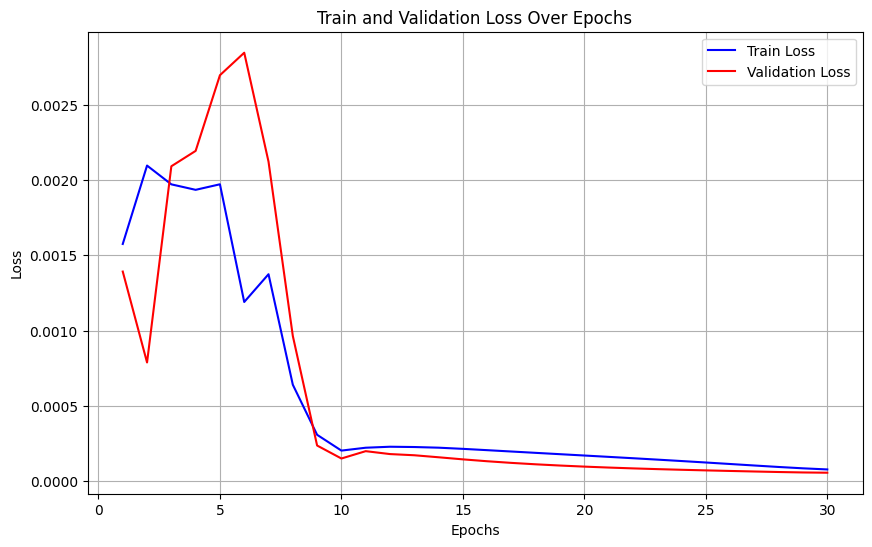

Mean Absolute Error (MAE): 6825.1998
Mean Squared Error (MSE): 63833915.2155
Root Mean Squared Error (RMSE): 7989.6130
R-squared (R²): 0.6910


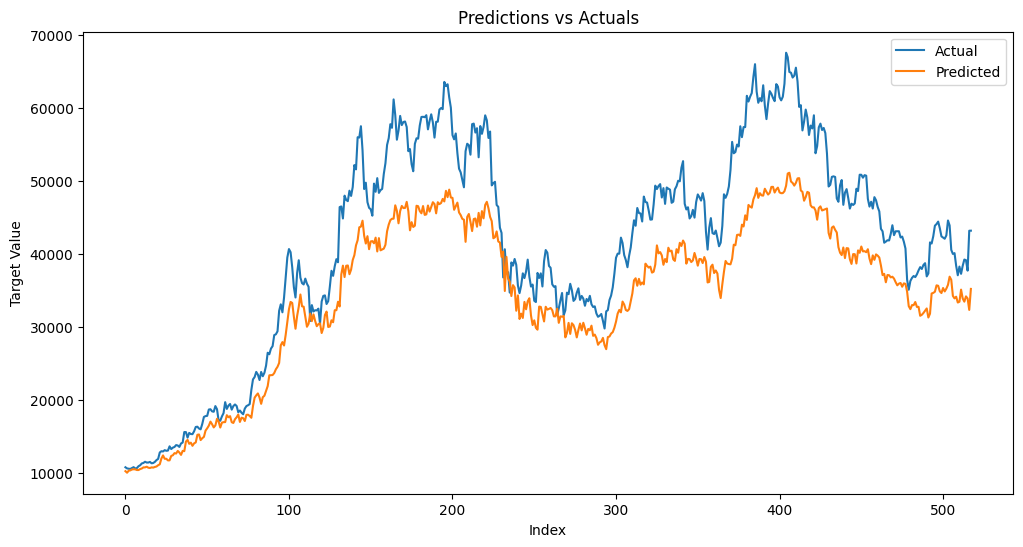

In [ ]:
# Example run
model, train_losses, valid_losses, test_preds, test_actuals = train_and_evaluate(train_data_final, valid_data, test_data, target_column_index=0,
                   n_timesteps=7, num_epochs=30, hidden_sizes=[50, 100], batch_size=20,
                   learning_rate=0.001)
metrics_and_plot(test_actuals, test_preds, scaler)

In [ ]:
model

RNNModel(
  (rnn_layers): ModuleList(
    (0): RNN(8, 50, batch_first=True)
    (1): RNN(50, 100, batch_first=True)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Epoch 2/30, Train Loss: 0.003046, Valid Loss: 0.004946
Epoch 4/30, Train Loss: 0.002271, Valid Loss: 0.002888
Epoch 6/30, Train Loss: 0.002134, Valid Loss: 0.001238
Epoch 8/30, Train Loss: 0.001470, Valid Loss: 0.000677
Epoch 10/30, Train Loss: 0.000734, Valid Loss: 0.000345
Epoch 12/30, Train Loss: 0.000188, Valid Loss: 0.000278
Epoch 14/30, Train Loss: 0.000175, Valid Loss: 0.000251
Epoch 16/30, Train Loss: 0.000180, Valid Loss: 0.000239
Epoch 18/30, Train Loss: 0.000170, Valid Loss: 0.000203
Epoch 20/30, Train Loss: 0.000161, Valid Loss: 0.000169
Epoch 22/30, Train Loss: 0.000152, Valid Loss: 0.000142
Epoch 24/30, Train Loss: 0.000143, Valid Loss: 0.000122
Epoch 26/30, Train Loss: 0.000135, Valid Loss: 0.000107
Epoch 28/30, Train Loss: 0.000128, Valid Loss: 0.000096
Epoch 30/30, Train Loss: 0.000122, Valid Loss: 0.000089


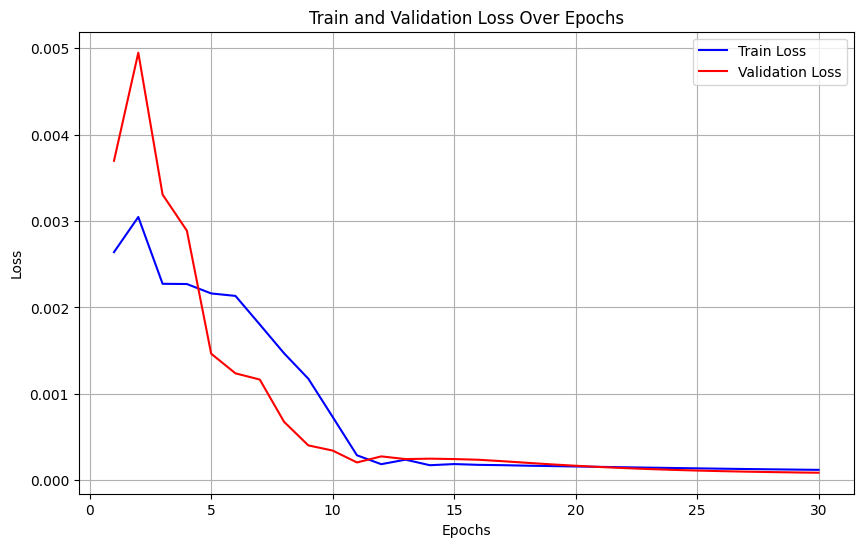

Mean Absolute Error (MAE): 7827.4821
Mean Squared Error (MSE): 82949613.1831
Root Mean Squared Error (RMSE): 9107.6678
R-squared (R²): 0.5985


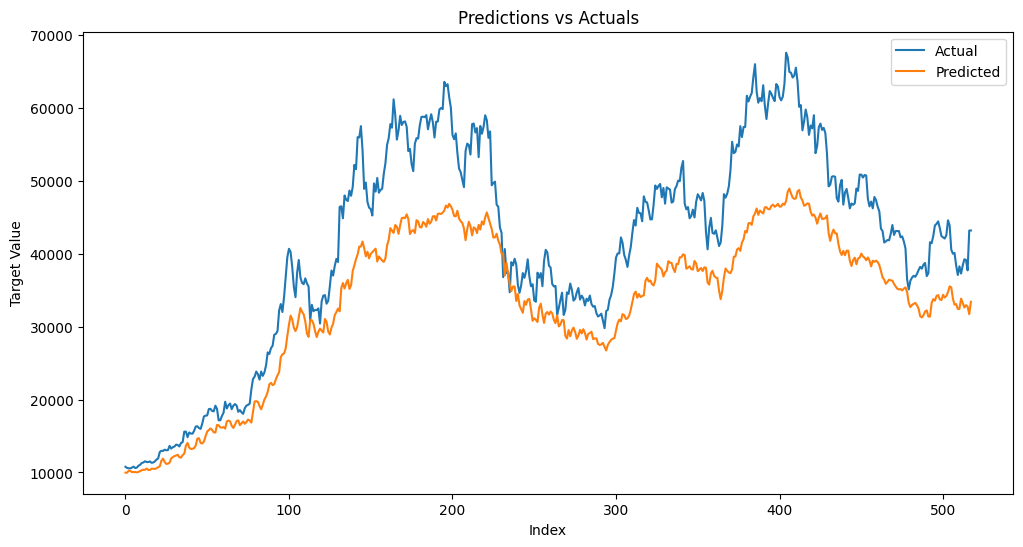

In [ ]:
# Example run 1
model, train_losses, valid_losses, test_preds, test_actuals = train_and_evaluate(train_data_final, valid_data, test_data, target_column_index=0,
                   n_timesteps=7, num_epochs=30, hidden_sizes=[50, 100], batch_size=30,
                   learning_rate=0.001)
metrics_and_plot(test_actuals, test_preds, scaler)

Epoch 2/10, Train Loss: 0.001230, Valid Loss: 0.000648
Epoch 4/10, Train Loss: 0.000548, Valid Loss: 0.000190
Epoch 6/10, Train Loss: 0.000294, Valid Loss: 0.000125
Epoch 8/10, Train Loss: 0.000208, Valid Loss: 0.000124
Epoch 10/10, Train Loss: 0.000177, Valid Loss: 0.000114


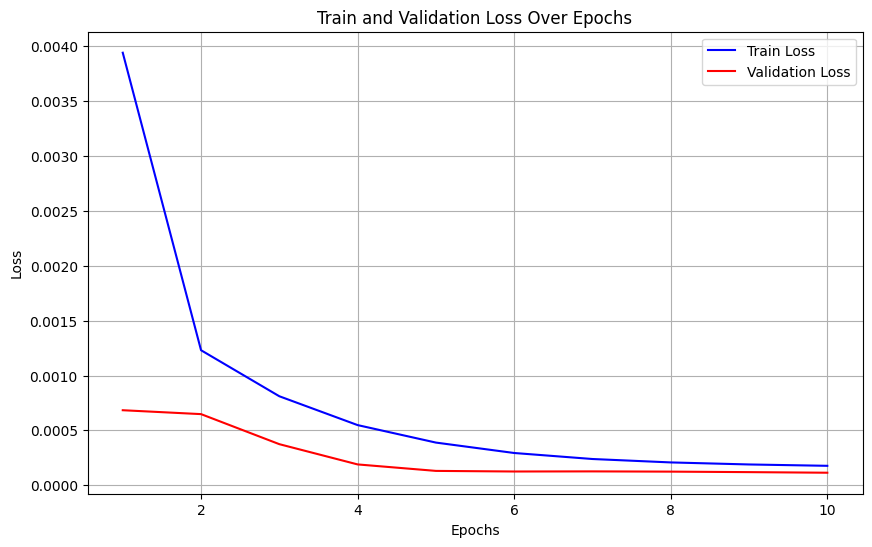

Mean Absolute Error (MAE): 6368.6073
Mean Squared Error (MSE): 58403455.4864
Root Mean Squared Error (RMSE): 7642.2154
R-squared (R²): 0.7173


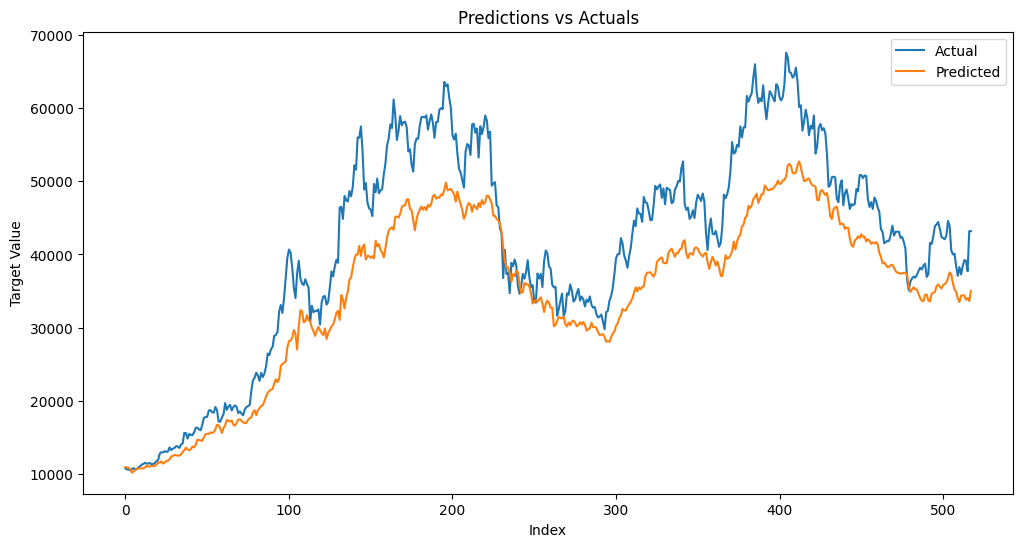

In [ ]:
# Example run 2
model, train_losses, valid_losses, test_preds, test_actuals = train_and_evaluate(train_data_final, valid_data, test_data, target_column_index=0,
    n_timesteps=7, num_epochs=10, hidden_sizes=[50], batch_size=16,learning_rate=0.0005)
metrics_and_plot(test_actuals, test_preds, scaler)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10, Train Loss: 0.000138, Valid Loss: 0.000456
Epoch 4/10, Train Loss: 0.000156, Valid Loss: 0.000601
Epoch 6/10, Train Loss: 0.000156, Valid Loss: 0.000628
Epoch 8/10, Train Loss: 0.000135, Valid Loss: 0.000618
Epoch 10/10, Train Loss: 0.000136, Valid Loss: 0.000743


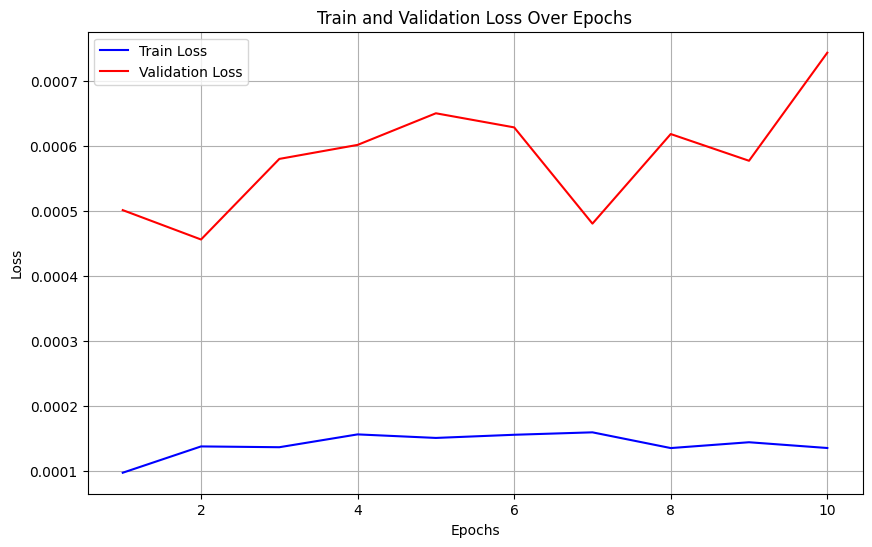

Mean Absolute Error (MAE): 23119.7094
Mean Squared Error (MSE): 643196231.1454
Root Mean Squared Error (RMSE): 25361.3137
R-squared (R²): -2.2734


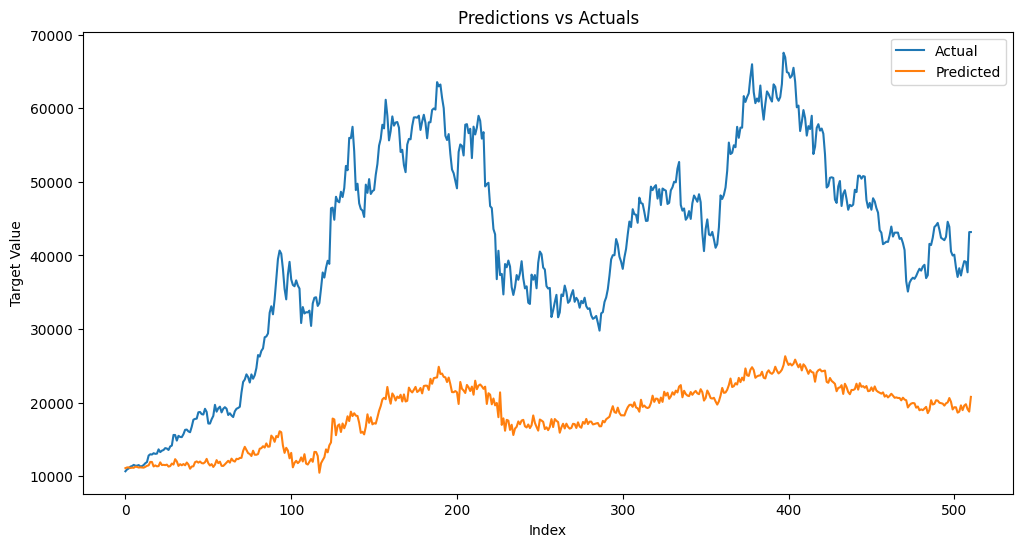

In [ ]:
# Example run 3
model, train_losses, valid_losses, test_preds, test_actuals = train_and_evaluate(train_data_final, valid_data, test_data, target_column_index=0,n_timesteps=14, num_epochs=10, hidden_sizes=[50], batch_size=1, learning_rate=0.0005)
metrics_and_plot(test_actuals, test_preds, scaler)


Epoch 2/20, Train Loss: 0.002219, Valid Loss: 0.001880
Epoch 4/20, Train Loss: 0.002209, Valid Loss: 0.003735
Epoch 6/20, Train Loss: 0.001813, Valid Loss: 0.003129
Epoch 8/20, Train Loss: 0.001497, Valid Loss: 0.002109
Epoch 10/20, Train Loss: 0.000842, Valid Loss: 0.001385
Epoch 12/20, Train Loss: 0.000238, Valid Loss: 0.000213
Epoch 14/20, Train Loss: 0.000200, Valid Loss: 0.000191
Epoch 16/20, Train Loss: 0.000205, Valid Loss: 0.000177
Epoch 18/20, Train Loss: 0.000191, Valid Loss: 0.000146
Epoch 20/20, Train Loss: 0.000174, Valid Loss: 0.000120


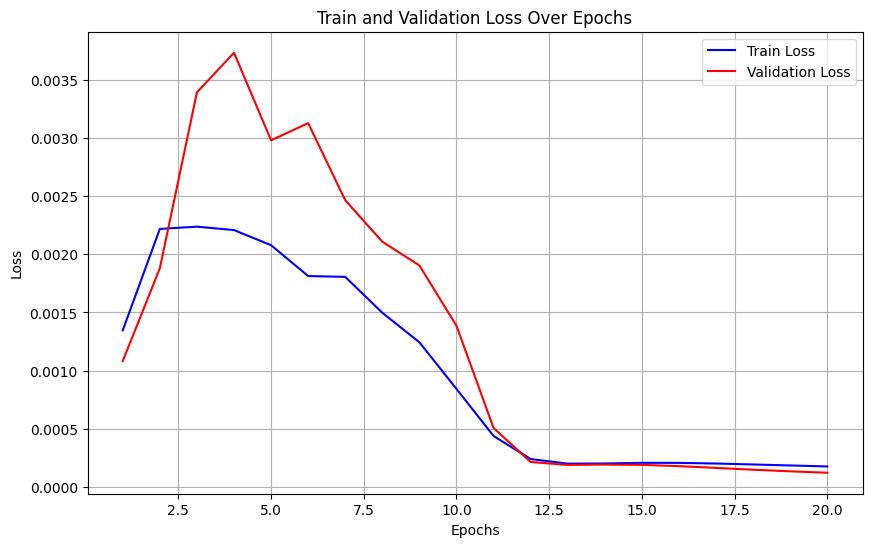

Mean Absolute Error (MAE): 11672.7543
Mean Squared Error (MSE): 171261036.5292
Root Mean Squared Error (RMSE): 13086.6740
R-squared (R²): 0.0084


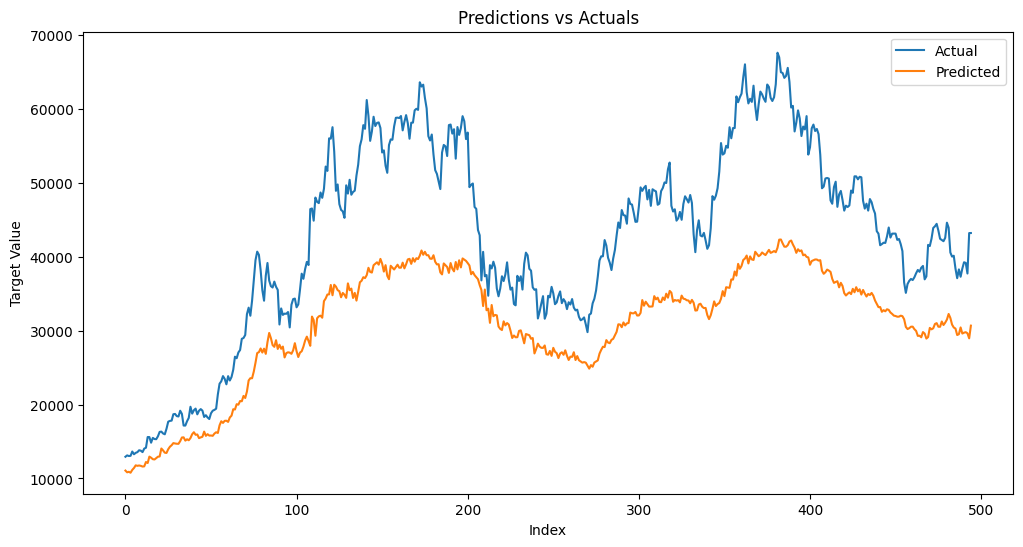

In [ ]:
# Example run 4
model, train_losses, valid_losses, test_preds, test_actuals = train_and_evaluate(train_data_final, valid_data, test_data, target_column_index=0,
    n_timesteps=30, num_epochs=20, hidden_sizes=[50,100], batch_size=16,learning_rate=0.0005)
metrics_and_plot(test_actuals, test_preds, scaler)

Summary of Hyperparameter Experiments

**Hidden Layers (hidden_sizes**)

*   More layers did not improve accuracy and sometimes led to overfitting.

**Learning rates**

*   Lower learning rates (0.0005) worked better, while higher ones (0.001) caused instability.


**Batch Size**

Batch size 16 gave the best results, balancing stability and generalization.

*   Batch size 30 showed no clear improvement over 16.


**---- Conclusion: ----**

Best parameters set: n_timesteps=7, num_epochs=10, hidden_sizes=[50], batch_size=16,learning_rate=0.0005

### Model performance

With the above settings, the performance on test set is as follow:
- Mean Absolute Error (MAE): 6368.6073
- Root Mean Squared Error (RMSE): 7642.2154
- R-squared (R²): 0.7173


The model explains about 71.73% of the variance in Bitcoin price. The RMSE (7642) is smaller than the dataset's standard deviation (16198), indicating the model is making meaningful predictions, but errors are still relatively high in absolute terms.

The dataset is quite simple with just only 2 primary features, that can be the reason why a simpler configuration give better result. A simpler RNN avoids overfitting and generalizes better. A single hidden layer (50) captures patterns without unnecessary complexity. The learning rate (0.0005) ensures stability, and 7 timesteps provide enough context without adding noise.

#### Potential improvements

- External Features: The model relied exclusively on Bitcoin’s historical price and volume data, which may have limited its performance. Factors like news sentiment, global market conditions, or macroeconomic events could further enhance predictions.

- Ensemble Models: Combining RNNs with other machine learning models